The purpose of this notebook is to experiment with different models and try to train one that can rank a number of given days from most to least profitable.

In [1]:
import pandas as pd
import numpy as np

In [2]:
pd.set_option('max.columns', None)

df = pd.read_csv('../data-prep/surfa_combined_dataset.csv', parse_dates=['Date'])
df.tail()

,Date,TipPerHour,IsWeekend,DayOfWeek,MaxWindHour,MaxWindGustHour,MaxHum,VisibilityNoon
95,2021-03-11,0.000,0.0,3,10.0,10.0,95.0,68.00
96,2021-03-12,0.000,1.0,4,12.0,12.0,86.0,66.00
97,2021-03-13,0.000,1.0,5,7.0,12.0,93.0,67.00
98,2021-03-14,0.664,1.0,6,14.0,14.0,96.0,75.75
99,2021-03-17,0.244,0.0,2,12.0,14.0,98.0,66.75


## The evaluation criterion

To be able to evaluate if our model is accurate enough or not, we need to create a base for comparison.

If a human human makes guesses with a probability that matches the distribuition, the r^2 score of those predictions will be around -0.45.

In [6]:
from random import choices
from sklearn.metrics import r2_score

binned = pd.cut(df['TipPerHour'], np.arange(-0.1, 1, 0.1))
binned = binned.apply(lambda x: float(x.right))
tip_distribution = binned.groupby(binned).count()

sum=0
for _ in range(0,500):
    sum += r2_score(df['TipPerHour'], choices(tip_distribution.index.values, tip_distribution, k=100))
print(sum/500)


-0.4578868332189186


As a result any algorythm with an r2 score of over -0.45 would predict better than a human guess and would be considered useful.

# Feature selection

Here we analyse the available features and choose which ones to use.

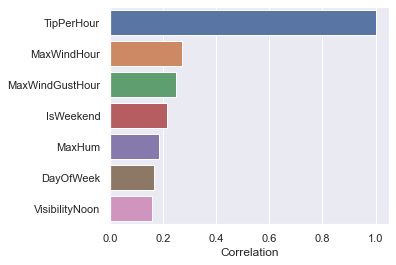

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))

cofs = df.corr()[['TipPerHour']]
cofs['AbsCoef'] = cofs['TipPerHour'].apply(abs)

cofs = cofs.sort_values('AbsCoef', ascending=False)

sns.set_theme()
ax = sns.barplot(data=cofs, x='AbsCoef', y=cofs.index)
ax.axes.set_xlabel("Correlation")
plt.show()

We can use `f_regression` to find the fscore (correlation strength) and p-value (probability that the correlation is due to pure chance) to choose most relevant features.

In [4]:
from sklearn.feature_selection import SelectKBest, f_regression

pdf = df.drop(columns=['Date', 'TipPerHour']).copy()
X = pdf
y = df['TipPerHour']

f_score, p_val = f_regression(pdf, y)

kbest = pd.DataFrame({'column':pdf.columns, 'fscore': f_score, 'pval':p_val})\
    .sort_values('fscore', ascending=False)\
    .reset_index(drop=True)
kbest.head(7)

,column,fscore,pval
0,MaxWindHour,7.789108,0.006318
1,MaxWindGustHour,6.442762,0.012716
2,IsWeekend,4.837673,0.030196
3,MaxHum,3.529429,0.063261
4,DayOfWeek,2.792982,0.097868
5,VisibilityNoon,2.574424,0.111822


Here we see the first three features have a significant correlation (pval > 0.05) and an acceptable fscore. We will use them for training since adding more features makes the model haardeer to train, evaluate and deploy, all the while providing limited benefits.

In [5]:
selector = SelectKBest(f_regression, k=3).fit(X, y)
pdf.iloc[:,selector.get_support(indices=True)]
X_select = selector.transform(X)


# Predictions

Now we will try different models using GridSearch to find the best parameters

In [6]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler

First I like the idea behind SVR so we'll start with them.

In [7]:
svr_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', SVR())
])

In [8]:
parameters = {
    'model__kernel':('linear', 'rbf', 'sigmoid', 'poly'), 
    'model__gamma': ['auto', 'scale', *np.logspace(-5, 1, base=2, num=10)] ,
    }   


grid = GridSearchCV(svr_pipe, parameters, cv=5, verbose=1, n_jobs=2)

grid.fit(X_select, y)



Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', SVR())]),
             n_jobs=2,
             param_grid={'model__gamma': ['auto', 'scale', 0.03125,
                                          0.049606282874006244,
                                          0.07874506561842956, 0.125,
                                          0.19842513149602492,
                                          0.31498026247371824, 0.5,
                                          0.7937005259840995, 1.259921049894873,
                                          2.0],
                         'model__kernel': ('linear', 'rbf', 'sigmoid', 'poly')},
             verbose=1)

In [9]:
def display_results(grid, cols = []):
    s = set()
    for p in grid.param_grid if type(grid.param_grid) == list else [grid.param_grid]:
        s = s.union(['param_' + name for name in p.keys()])

    return pd.DataFrame(grid.cv_results_)\
        .sort_values('mean_test_score', ascending=False)\
        [['mean_fit_time', *s, *cols, 'mean_test_score', 'std_test_score']]

In [10]:
display_results(grid).head(5)

,mean_fit_time,param_model__gamma,param_model__kernel,mean_test_score,std_test_score
37,0.002142,0.793701,rbf,0.051141,0.224180
41,0.002534,1.259921,rbf,0.026062,0.247826
33,0.001800,0.5,rbf,0.009965,0.197614
45,0.004402,2.0,rbf,-0.005410,0.235921
27,0.002823,0.198425,poly,-0.008418,0.134300


The best performance came from an rbf kernel and the worst – from a sigmoid one. 

The sigmoid was probably so bad because of some hyperparameters.

And since the default of gamma is  1 / (n_features * X.var()) i think the value of 1000 is way too high for it, and it was reduced. 

The docs seem to recomend a log range from 10^-3 to 10^3.

Now it may be time to introduce the `C` hyperparameter.

RBF seems to still be the best fitting kernel by far so we'll focus on it for now.

In [11]:

parameters = [
    {
        'model__kernel':['poly', 'rbf'], 
        'model__gamma': ['auto', 'scale', 1, *np.logspace(-5, 2, base=2, num=12)] ,
        'model__C': np.logspace(-5, 1, base=2, num=12) ,
    }
]

grid1 = GridSearchCV(svr_pipe, parameters, cv=5, n_jobs = 2, verbose=1)

_ = grid1.fit(X_select, y)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


In [12]:
display_results(grid1).head(5)

,mean_fit_time,param_model__gamma,param_model__kernel,param_model__C,mean_test_score,std_test_score
245,0.001932,1,rbf,0.643332,0.069201,0.205638
263,0.002201,1.065041,rbf,0.643332,0.067012,0.204927
233,0.002010,1.065041,rbf,0.440796,0.056952,0.173469
215,0.001606,1,rbf,0.440796,0.054942,0.167875
261,0.001732,0.685175,rbf,0.643332,0.053005,0.174620


With this parameter we have slightly improved the r^2 score, but not enough.

I've heard that random forests are "Surprisingly good", let's see how they perform

In [42]:
from sklearn.ensemble import RandomForestRegressor

forest_pipe =  Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', RandomForestRegressor())
])

scalerless_forest_pipe = Pipeline(steps=[
    ('model', RandomForestRegressor())
])

In [20]:

parameters = [
    {
    'model__max_depth': [10, 50, 80, 120],
    'model__max_features': [1, 2, 3],
    'model__min_samples_leaf': [3, 5, 6],
    'model__min_samples_split': [2, 7, 10, 15, 20],
    'model__n_estimators': [3, 5, 15]
    }
]

grid2 = GridSearchCV(forest_pipe, parameters, cv=5, n_jobs=3, verbose=2)

_ = grid2.fit(X_select, y)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


In [23]:
rfdf = display_results(grid2)
rfdf.head(5)

,mean_fit_time,param_model__n_estimators,param_model__max_features,param_model__min_samples_leaf,param_model__max_depth,param_model__min_samples_split,mean_test_score,std_test_score
28,0.011999,5,1,5,10,20,0.070341,0.177582
370,0.014206,5,3,3,80,15,0.070200,0.110976
88,0.013990,5,2,6,10,20,0.069455,0.059786
151,0.012999,5,1,5,50,2,0.065525,0.156046
447,0.013202,3,1,6,120,20,0.065379,0.163632


The Random Forset provides a significant improvement. 

However it's still not clear what some parameters mean. Let's look into how the hyperparameters influence the score.

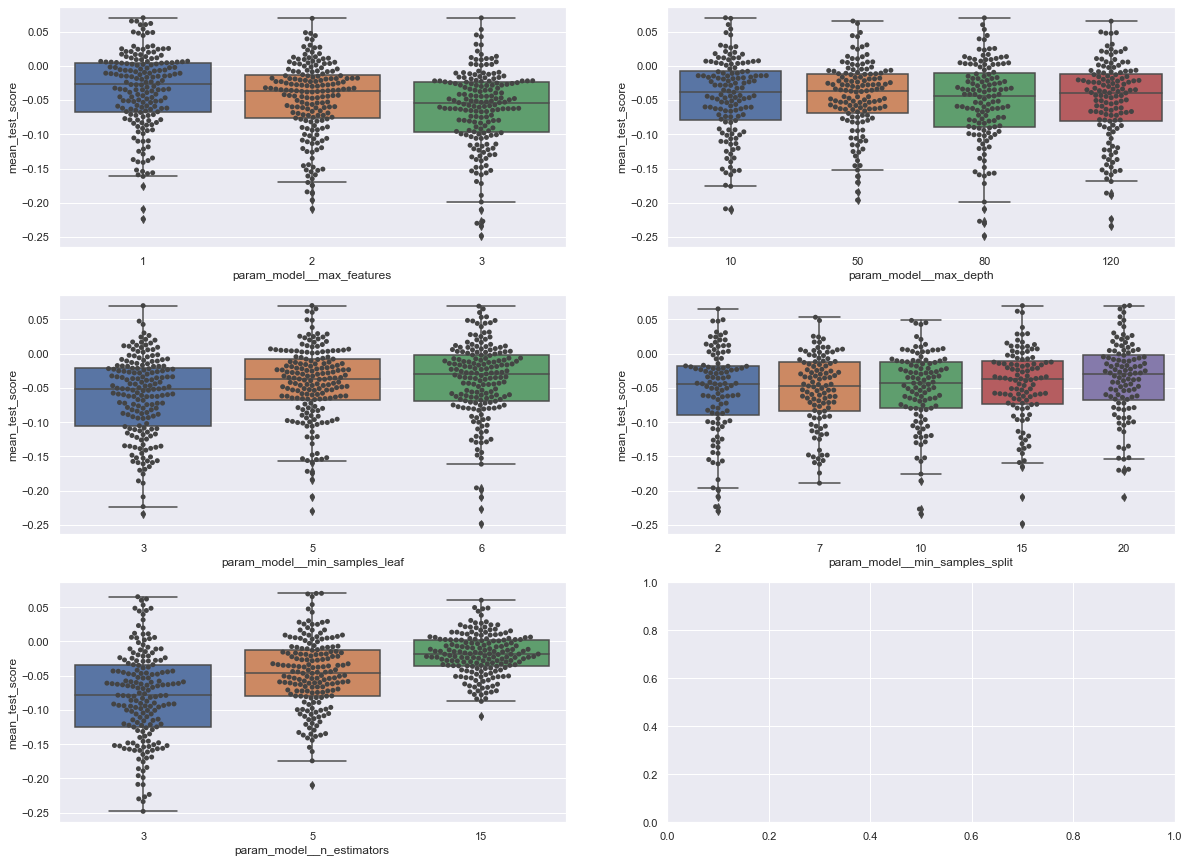

In [24]:
fig, ((ax_feats, ax_max_depth), (ax_samp_leaf, ax_samp_split), (ax_estimators, _)) = plt.subplots(3, 2, figsize=(20, 15))

def plot_feats(**kwargs):
    sns.boxplot(**kwargs)
    sns.swarmplot(**kwargs, color='#444')

plot_feats(data= rfdf, x = 'param_model__max_features', y = 'mean_test_score', ax=ax_feats)
plot_feats(data= rfdf, x = 'param_model__max_depth', y = 'mean_test_score', ax=ax_max_depth)
plot_feats(data= rfdf, x = 'param_model__min_samples_leaf', y = 'mean_test_score', ax=ax_samp_leaf)
plot_feats(data= rfdf, x = 'param_model__min_samples_split', y = 'mean_test_score', ax=ax_samp_split)
plot_feats(data= rfdf, x = 'param_model__n_estimators', y = 'mean_test_score', ax=ax_estimators)


All parameters seem to be very similar, except the number of esetimators which clearly has a higher floor on accuracy, but the same ceiling, which makes sense, it is not much of a forest if it has 1 or 3 trees. Perhpas we should try a wider range of parameters with a higher number of estimators.

In [25]:
from sklearn.ensemble import RandomForestRegressor

parameters = [
    {
    'model__max_depth': [10, 50, 80, 120],
    'model__min_samples_leaf': [5, 9, 13, 17],
    'model__min_samples_split': [2, 10, 15, 20, 25, 30],
    'model__n_estimators': [15, 20, 30]
    }
]

grid3 = GridSearchCV(forest_pipe, parameters, cv=5, n_jobs=3, verbose=2)

_ = grid3.fit(X_select, y)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


In [26]:
display_results(grid3).head(5)

,mean_fit_time,param_model__n_estimators,param_model__max_depth,param_model__min_samples_split,param_model__min_samples_leaf,mean_test_score,std_test_score
285,0.032041,15,120,30,17,0.052786,0.096865
258,0.034650,15,120,15,13,0.042981,0.086864
133,0.046801,20,50,15,17,0.039468,0.098173
128,0.071199,30,50,2,17,0.034922,0.091615
252,0.037006,15,120,2,13,0.033739,0.102281


These parameters display significantly lower scores.

Also the standard deviation of the test score across fold is very heigh for all the models so far, some folds are performing way better than others, which is weird and reminds me that our data is ordered and we ought to shuffle the dataset.

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.preprocessing import FunctionTransformer

In [28]:
pipe = Pipeline(steps=[
    ('shuffle', FunctionTransformer(shuffle, kw_args={'random_state':42})),
    ('scale', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators = 200))
])

parameters = [
    {
    'model__max_depth': [80, 90, 100, 120],
    'model__max_features': [2, 3],
    'model__min_samples_leaf': [3, 5, 6],
    'model__min_samples_split': [2, 5, 8, 10, 12],
    'model__n_estimators': [5, 15],
    }
]

grid5 = GridSearchCV(pipe, parameters, cv=5, n_jobs=3, verbose=2)


grid5.fit(X_select, y)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('shuffle',
                                        FunctionTransformer(func=<function shuffle at 0x000001A1E9B62E50>,
                                                            kw_args={'random_state': 42})),
                                       ('scale', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(n_estimators=200))]),
             n_jobs=3,
             param_grid=[{'model__max_depth': [80, 90, 100, 120],
                          'model__max_features': [2, 3],
                          'model__min_samples_leaf': [3, 5, 6],
                          'model__min_samples_split': [2, 5, 8, 10, 12],
                          'model__n_estimators': [5, 15]}],
             verbose=2)

In [29]:
display_results(grid5).head(5)

,mean_fit_time,param_model__n_estimators,param_model__max_features,param_model__min_samples_leaf,param_model__max_depth,param_model__min_samples_split,mean_test_score,std_test_score
136,0.014800,5,2,5,100,10,-0.162365,0.089614
16,0.026458,5,2,5,80,10,-0.171175,0.241699
88,0.028254,5,2,6,90,12,-0.179635,0.182290
86,0.021457,5,2,6,90,10,-0.180474,0.141020
69,0.051604,15,2,3,90,12,-0.188481,0.194650


The performance with the shuffled data is so terrible it must mean that either
*   The ordering introduced a significant bias
*   The shuffle did not run as expected and the results of the shuffle are invalid.
Since we cannot be sure how the pipeline executed the shuffle, we'll do it ourselves to see if there is any difference.

In [37]:
X_shuffle, y_shuffle = shuffle(X_select, y, random_state=42) 

In [33]:
from sklearn.ensemble import RandomForestRegressor

pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators = 200))
])

parameters = [
    {
    'model__max_depth': [80, 90, 100, 120],
    'model__max_features': [1, 2, 3],
    'model__min_samples_leaf': [3, 5, 6],
    'model__min_samples_split': [2, 5, 8, 10, 12],
    'model__n_estimators': [1,3, 5, 15]
    }
]

grid6 = GridSearchCV(pipe, parameters, cv=5, n_jobs=3, verbose=2)

grid6.fit(X_shuffle, y_shuffle)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(n_estimators=200))]),
             n_jobs=3,
             param_grid=[{'model__max_depth': [80, 90, 100, 120],
                          'model__max_features': [1, 2, 3],
                          'model__min_samples_leaf': [3, 5, 6],
                          'model__min_samples_split': [2, 5, 8, 10, 12],
                          'model__n_estimators': [1, 3, 5, 15]}],
             verbose=2)

In [35]:
display_results(grid6).head(5)

,mean_fit_time,param_model__n_estimators,param_model__max_features,param_model__min_samples_leaf,param_model__max_depth,param_model__min_samples_split,mean_test_score,std_test_score
20,0.004602,1,1,5,80,2,0.060022,0.180288
646,0.019399,5,2,6,120,5,0.048300,0.104942
213,0.010447,3,1,5,90,10,0.040988,0.091920
105,0.013260,3,2,6,80,5,0.035626,0.088790
395,0.047510,15,1,5,100,10,0.031141,0.057766


At first it looked like shufling the dataset has increased the accuracy and decreased the standard deviation. 

But, after repeated runs (with different `random_state`) it turned out that the standard deviation decreassed a bit, but the score would fluctuate  considerably between runs, ranging from 0 to 0.14 for the same model dependending on the shuffle.

To be fair to the SVR we should give it a go with randomized data too.

In [34]:

parameters = [
    {
        'model__kernel':['rbf', 'poly'], 
        'model__gamma': ['auto', 'scale', 1, *np.logspace(-6, 1.5, base=2, num=12)] ,
        'model__C': np.logspace(-6, 1.5, base=2, num=12) ,
    }
]

grid7 = GridSearchCV(svr_pipe, parameters, cv=5, verbose=3, n_jobs=3)

_ = grid7.fit(X_shuffle, y_shuffle)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


In [36]:
display_results(grid7).head(5)

,mean_fit_time,param_model__gamma,param_model__kernel,param_model__C,mean_test_score,std_test_score
214,0.005636,1,rbf,0.427124,0.002637,0.151838
234,0.003675,1.099131,rbf,0.427124,0.001411,0.144653
204,0.003105,1.099131,rbf,0.26626,-0.002770,0.116815
184,0.002604,1,rbf,0.26626,-0.003866,0.123273
232,0.002791,0.685175,rbf,0.427124,-0.010133,0.173398


The shuffle seems to have decreased the results of the SVR a lot. Which is strange because in a precious run with another random_state the SVR performed as well as before the shuffle.

We learnedd that tree-based models don't usually need normalisation at all, except that removing it seems to hurt the model.

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.preprocessing import FunctionTransformer


pipe = Pipeline(steps=[
    ('model', RandomForestRegressor())
])

parameters = [
    {
    'model__max_depth': [80, 90, 100, 120],
    'model__max_features': [2, 3],
    'model__min_samples_leaf': [2, 3, 5, 6],
    'model__min_samples_split': [2, 5, 8, 10, 12],
    'model__n_estimators': [2, 3, 5, 15],
    }
]

grid8 = GridSearchCV(pipe, parameters, cv=5, n_jobs=3, verbose=2)



grid8.fit(X_shuffle, y_shuffle)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


KeyboardInterrupt: 

In [39]:
display_results(grid8).head(8)

,mean_fit_time,param_model__n_estimators,param_model__min_samples_leaf,param_model__max_features,param_model__min_samples_split,param_model__max_depth,mean_test_score,std_test_score
426,0.013624,5,3,3,5,100,0.082782,0.079906
78,0.014804,5,6,2,12,80,0.044544,0.090771
585,0.009350,3,3,3,5,120,0.043175,0.143583
280,0.007996,2,5,3,2,90,0.037760,0.179014
263,0.039593,15,3,3,2,90,0.033913,0.136619
363,0.039561,15,5,2,2,100,0.033562,0.097264
293,0.008998,3,5,3,10,90,0.027071,0.107326
337,0.010371,3,2,2,12,100,0.026901,0.225701


# Ranking

Now r2_score is not necessairly a good metric for this model to begin with.

An accurate prediction of the tip would be great, but given that tips are "human behaviour" it may be impossible to predict well. Most importantly it may also be unnecessary. The goal of the project can be achieved by a model that succesfully ranks a number of future shifts from most to least proffitable or one that selects k most profitable shifts out of a list.

Now we will try to implement a ranking model and create a ranking-based scoring function that prioritises aspects important to our project.

I could not find any models that are specialized in ranking, so we will continue trying to predict the tip, but score based on the ranking. 

In [46]:
def rank(values: np.ndarray):
    ranking = np.zeros(len(values)).astype(int)
    
    for val in range(len(values)):
        for rank in range(len(ranking)):
            if values[val] > values[rank]:
                ranking[rank] += 1

    return ranking

def weighted_ranking_score(y_true: pd.Series, y_pred: np.ndarray):
    length = len(y_true)
    true_rank = rank(y_true.values)
    pred_rank = rank(y_pred)

    residuals = abs(true_rank-pred_rank)

    weights = 1 - (true_rank/length)

    wres =  residuals * weights

    
    loss = wres.sum() / np.array(range(length)).sum()

    # print('loss is ', loss)
    # print(pd.DataFrame({'t': y_true, 'tr':true_rank, 'p':y_pred, 'pr':pred_rank, 'res': residuals, 'w':weights, 'wres':wres}))
    return 1 - loss
    
weighted_ranking_score(pd.Series([2,2,2,2,2]), pd.Series([1,2,3,4,5]))

0.0

In order to evaluate the performance of the model we need to have a base for comparison.

Our goal is to create a model that is more accurate than humans. Since we do not have acces to actual predictions we will try to emulate some.

If the driver choses the days at random their score is about 0.64

In [47]:
sum=0
for _ in range(0,700):
    sample_week = df.sample(7).reset_index()['TipPerHour']
    sum += weighted_ranking_score(sample_week, sample_week.sample(frac=1).values)
print(sum/700)

0.6400680272108841


If a driver tries to chooses days that are later in the week, their score is about 0.55.

In [49]:
sum = 0
for _ in range(0,700):
    sample_week = df.sample(7).reset_index().sort_values('DayOfWeek')['TipPerHour']

    sum += weighted_ranking_score(sample_week, np.linspace(0,1,7))
print(sum/700)

0.570485908649174


With these results we decide that models performing better than 0.64 are considered more performant than humans.

Now we will implement this new score to find the best model.

In [47]:
from sklearn.metrics import make_scorer
ranking_scorer = make_scorer(weighted_ranking_score)

In [50]:

parameters = [
    {
    'model__max_depth': [80, 90, 100, 120],
    'model__max_features': [2, 3],
    'model__min_samples_leaf': [2, 3, 5, 6],
    'model__min_samples_split': [2, 5, 8, 10, 12],
    'model__n_estimators': [2, 3, 5, 15],
    }
]

grid9a = GridSearchCV(forest_pipe, parameters, cv=5, n_jobs=3, verbose=1, scoring=ranking_scorer)



grid9a.fit(X_shuffle, y_shuffle)

Fitting 5 folds for each of 640 candidates, totalling 3200 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', RandomForestRegressor())]),
             n_jobs=3,
             param_grid=[{'model__max_depth': [80, 90, 100, 120],
                          'model__max_features': [2, 3],
                          'model__min_samples_leaf': [2, 3, 5, 6],
                          'model__min_samples_split': [2, 5, 8, 10, 12],
                          'model__n_estimators': [2, 3, 5, 15]}],
             scoring=make_scorer(weighted_ranking_score), verbose=1)

In [51]:
display_results(grid9a).head(5)

,mean_fit_time,param_model__n_estimators,param_model__max_features,param_model__min_samples_leaf,param_model__max_depth,param_model__min_samples_split,mean_test_score,std_test_score
340,0.007200,2,2,3,100,2,0.707579,0.061088
328,0.007600,2,2,2,100,8,0.704632,0.031027
393,0.006198,3,2,6,100,10,0.703579,0.055092
164,0.005600,2,2,2,90,5,0.701211,0.038903
349,0.007596,3,2,3,100,8,0.698105,0.040034


No we see a model with an accuracy of 0.71 nad standard deviation of 0.4 which is pretty good. 

I only worry because all these random forest have few estimators, low min sample leaves and big max depth. These may indicate that the Random forest could be overfitting.

In either cacse let's try again other models that we have seen before.

In [65]:
parameters = [
    {
        'model__kernel':['rbf', 'poly'], 
        'model__gamma': ['auto', 'scale', 1, *np.logspace(-10, 1, base=2, num=12)] ,
        'model__C': np.logspace(-10, 1, base=2, num=12) ,
    }
]

grid9b = GridSearchCV(svr_pipe, parameters, cv=5, n_jobs= 3, scoring=ranking_scorer, verbose=1)

grid9b.fit(X_shuffle, y_shuffle)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', SVR())]),
             n_jobs=3,
             param_grid=[{'model__C': array([9.765625e-04, 1.953125e-03, 3.906250e-03, 7.812500e-03,
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00]),
                          'model__gamma': ['auto', 'scale', 1, 0.0009765625,
                                           0.001953125, 0.00390625, 0.0078125,
                                           0.015625, 0.03125, 0.0625, 0.125,
                                           0.25, 0.5, 1.0, 2.0],
                          'model__kernel': ['rbf', 'poly']}],
             scoring=make_scorer(weighted_ranking_score), verbose=1)

In [ ]:
display_results(grid9b).sort_values('mean_fit_time', ascending=False).head(5)

,mean_fit_time,param_model__kernel,param_model__gamma,param_model__C,mean_test_score,std_test_score
169,0.005992,poly,0.078745,0.125,0.688789,0.034905
145,0.001603,poly,0.135007,0.049606,0.687316,0.035265
53,0.003003,poly,auto,0.0031,0.687316,0.035265
55,0.003002,poly,scale,0.0031,0.687316,0.035265
21,0.002801,poly,0.680395,0.000488,0.686211,0.033637


SVR seems to be performing almost as good as RF with the new metric. 

In [66]:
X_small, y_small = shuffle(pdf[['IsWeekend','MaxHum']].values, y, random_state=42) 

In [72]:
parameters = [
    {
        'model__kernel':['rbf', 'poly'], 
        'model__gamma': ['auto', 'scale', 1, *np.logspace(-10, 3, base=2, num=10) ],
        'model__C': np.logspace(-10, 3, base=2, num=10) ,
    }
]

grid10a = GridSearchCV(svr_pipe, parameters, cv=5, n_jobs= 3, scoring=ranking_scorer, verbose=1)

grid10a.fit(X_small, y_small)

Fitting 5 folds for each of 260 candidates, totalling 1300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', SVR())]),
             n_jobs=3,
             param_grid=[{'model__C': array([9.76562500e-04, 2.65779297e-03, 7.23339619e-03, 1.96862664e-02,
       5.35777489e-02, 1.45816130e-01, 3.96850263e-01, 1.08005974e+00,
       2.93946898e+00, 8.00000000e+00]),
                          'model__gamma': ['auto', 'scale', 1, 0.0009765625,
                                           0.0026577929690905803,
                                           0.0072333961897444584,
                                           0.01968626640460739,
                                           0.05357774892831705,
                                           0.1458161299470146,
                                           0.39685026299204973,
                                           1.0800597388923059,
                                           2.939468984551197, 8.0],
               

In [75]:
display_results(grid10a).head(5)

,mean_fit_time,param_model__kernel,param_model__gamma,param_model__C,mean_test_score,std_test_score
197,0.001801,poly,0.053578,1.08006,0.702000,0.052768
45,0.001726,poly,0.39685,0.002658,0.702000,0.052768
121,0.002203,poly,0.145816,0.053578,0.702000,0.052768
29,0.003193,poly,scale,0.002658,0.701842,0.052712
27,0.002007,poly,auto,0.002658,0.701842,0.052712


It is interesting that a result almost as good can be achieved with a simple SVR with just three features.

In that case it is probably not worth adding more of the already existing features. Instead we would rather try to find other features.

In [100]:
parameters = [
    {
        'model__kernel':['rbf', 'poly'], 
        'model__gamma': ['auto', 'scale', 1, *np.logspace(-10, 2, base=2, num=10) ],
        'model__C': np.logspace(-10, 2, base=2, num=10) ,
    }
]

grid11a = GridSearchCV(svr_pipe, parameters, cv=5, n_jobs= 3, scoring=ranking_scorer, verbose=1)
grid11a.fit(*shuffle(pdf[['IsWeekend']].values, y, random_state=42) )

grid11b = GridSearchCV(svr_pipe, parameters, cv=5, n_jobs= 3, scoring=ranking_scorer, verbose=1)
grid11b.fit(*shuffle(pdf[['MaxWindHour']].values, y, random_state=42) )

grid11c = GridSearchCV(svr_pipe, parameters, cv=5, n_jobs= 3, scoring=ranking_scorer, verbose=1)
grid11c.fit(*shuffle(pdf[['MaxHum']].values, y, random_state=42) )

grid11d = GridSearchCV(svr_pipe, parameters, cv=5, n_jobs= 3, scoring=ranking_scorer, verbose=1)
grid11d.fit(*shuffle(pdf[['MaxHum', 'MaxWindHour']].values, y, random_state=42) )

grid11e = GridSearchCV(svr_pipe, parameters, cv=5, n_jobs= 3, scoring=ranking_scorer, verbose=1)
grid11e.fit(*shuffle(pdf[['MaxHum', 'MaxWindHour', 'IsWeekend']].values, y, random_state=42) )



Fitting 5 folds for each of 260 candidates, totalling 1300 fits
Fitting 5 folds for each of 260 candidates, totalling 1300 fits
Fitting 5 folds for each of 260 candidates, totalling 1300 fits
Fitting 5 folds for each of 260 candidates, totalling 1300 fits
Fitting 5 folds for each of 260 candidates, totalling 1300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', SVR())]),
             n_jobs=3,
             param_grid=[{'model__C': array([9.76562500e-04, 2.46078330e-03, 6.20078536e-03, 1.56250000e-02,
       3.93725328e-02, 9.92125657e-02, 2.50000000e-01, 6.29960525e-01,
       1.58740105e+00, 4.00000000e+00]),
                          'model__gamma': ['auto', 'scale', 1, 0.0009765625,
                                           0.002460783300575925,
                                           0.006200785359250777, 0.015625,
                                           0.03937253280921478,
                                           0.09921256574801243, 0.25,
                                           0.629960524947436, 1.587401051968199,
                                           4.0],
                          'model__kernel': ['rbf', 'poly']}],
             scoring=make_scorer(weighted_ranking_score), verbose=1

In [103]:
# IsWeekend
display_results(grid11a).head(5)

,mean_fit_time,param_model__kernel,param_model__gamma,param_model__C,mean_test_score,std_test_score
0,0.001057,rbf,auto,0.000977,0.638105,0.04939
163,0.002893,poly,0.000977,0.25,0.638105,0.04939
165,0.002417,poly,0.002461,0.25,0.638105,0.04939
166,0.001220,rbf,0.006201,0.25,0.638105,0.04939
167,0.002751,poly,0.006201,0.25,0.638105,0.04939


In [106]:
# MaxWindHour
display_results(grid11b).head(5)

,mean_fit_time,param_model__kernel,param_model__gamma,param_model__C,mean_test_score,std_test_score
259,0.193610,poly,4.0,4.0,0.676421,0.042827
1,0.002006,poly,auto,0.000977,0.676421,0.042827
133,0.004801,poly,scale,0.099213,0.676421,0.042827
237,0.002631,poly,scale,4.0,0.676421,0.042827
135,0.000000,poly,1,0.099213,0.676421,0.042827


In [105]:
# MaxHum
display_results(grid11c).head(5)

,mean_fit_time,param_model__kernel,param_model__gamma,param_model__C,mean_test_score,std_test_score
259,0.349829,poly,4.0,4.0,0.700263,0.044711
125,0.005945,poly,0.629961,0.039373,0.700263,0.044711
127,0.003204,poly,1.587401,0.039373,0.700263,0.044711
129,0.009600,poly,4.0,0.039373,0.700263,0.044711
1,0.001633,poly,auto,0.000977,0.700263,0.044711


In [108]:
# MaxHum, MaxWindHour
display_results(grid11d).head(5)

,mean_fit_time,param_model__kernel,param_model__gamma,param_model__C,mean_test_score,std_test_score
254,0.002300,rbf,0.629961,4.0,0.712105,0.045756
228,0.003743,rbf,0.629961,1.587401,0.711158,0.027329
236,0.003121,rbf,scale,4.0,0.710737,0.033279
234,0.005010,rbf,auto,4.0,0.710737,0.033279
159,0.001601,poly,scale,0.25,0.704579,0.029822


In [110]:
# MaxHum, MaxWindHour, IsWeekend
display_results(grid11e).head(5)

,mean_fit_time,param_model__kernel,param_model__gamma,param_model__C,mean_test_score,std_test_score
121,0.001706,poly,0.099213,0.039373,0.705368,0.04438
3,0.001608,poly,scale,0.000977,0.705368,0.04438
45,0.000000,poly,0.25,0.002461,0.705368,0.04438
197,0.000000,poly,0.039373,0.629961,0.705368,0.04438
1,0.001953,poly,auto,0.000977,0.705368,0.04438


We have tried multipe combinations of features and noticed that `MaxHum` and `MaxWindHour` together perform better than all of them separately, however adding `IsWeekend` seems to slightly remove from the performance.

However we are quite certain that `IsWeekend` does contain a significant and explainable correlation, while the reason `MaxHum` and `MaxWindHour` impact the prediciton remains unclear. It is possible that the correlation of `MaxHum` and `MaxWindHour` is partly due to chance and will not generalize well on unseen data.

Let's try the same experiment with Random Forests.

In [115]:
parameters = {
    'model__max_depth': [20, 80, 120],
    'model__min_samples_leaf': [2, 3, 5, 6],
    'model__min_samples_split': [2, 5, 10,],
    'model__n_estimators': [2, 5, 15],
    }

grid12a = GridSearchCV(forest_pipe, parameters, cv=5, n_jobs= 3, scoring=ranking_scorer, verbose=1)
grid12a.fit(*shuffle(pdf[['IsWeekend']].values, y, random_state=42) )

grid12b = GridSearchCV(forest_pipe, parameters, cv=5, n_jobs= 3, scoring=ranking_scorer, verbose=1)
grid12b.fit(*shuffle(pdf[['MaxWindHour']].values, y, random_state=42) )

grid12c = GridSearchCV(forest_pipe, parameters, cv=5, n_jobs= 3, scoring=ranking_scorer, verbose=1)
grid12c.fit(*shuffle(pdf[['MaxHum']].values, y, random_state=42) )

grid12d = GridSearchCV(forest_pipe, {**parameters, 'model__max_features': [1,2]}, cv=5, n_jobs= 3, scoring=ranking_scorer, verbose=1)
grid12d.fit(*shuffle(pdf[['MaxHum', 'MaxWindHour']].values, y, random_state=42) )

grid12e = GridSearchCV(forest_pipe, {**parameters, 'model__max_features': [1,2,3]}, cv=5, n_jobs= 3, scoring=ranking_scorer, verbose=1)
grid12e.fit(*shuffle(pdf[['MaxHum', 'MaxWindHour', 'IsWeekend']].values, y, random_state=42) )



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', RandomForestRegressor())]),
             n_jobs=3,
             param_grid={'model__max_depth': [20, 80, 120],
                         'model__max_features': [1, 2, 3],
                         'model__min_samples_leaf': [2, 3, 5, 6],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [2, 5, 15]},
             scoring=make_scorer(weighted_ranking_score), verbose=1)

In [116]:
# IsWeekend
display_results(grid12a).head(5)

,mean_fit_time,param_model__n_estimators,param_model__max_depth,param_model__min_samples_split,param_model__min_samples_leaf,mean_test_score,std_test_score
0,0.013081,2,20,2,2,0.638105,0.04939
68,0.031291,15,80,5,6,0.638105,0.04939
79,0.015361,5,120,10,2,0.638105,0.04939
78,0.006698,2,120,10,2,0.638105,0.04939
77,0.028962,15,120,5,2,0.638105,0.04939


In [117]:
# MaxWindHour
display_results(grid12b).head(5)

,mean_fit_time,param_model__n_estimators,param_model__max_depth,param_model__min_samples_split,param_model__min_samples_leaf,mean_test_score,std_test_score
87,0.007234,2,120,10,3,0.701368,0.037661
102,0.005389,2,120,5,6,0.697105,0.044873
6,0.009723,2,20,10,2,0.688211,0.043814
96,0.008649,2,120,10,5,0.686105,0.009658
60,0.008301,2,80,10,5,0.681263,0.062298


In [118]:
# MaxHum
display_results(grid12c).head(5)

,mean_fit_time,param_model__n_estimators,param_model__max_depth,param_model__min_samples_split,param_model__min_samples_leaf,mean_test_score,std_test_score
9,0.027387,2,20,2,3,0.689211,0.064133
63,0.007300,2,80,2,6,0.685474,0.039248
87,0.008549,2,120,10,3,0.685263,0.050874
81,0.008634,2,120,2,3,0.683684,0.047665
78,0.008716,2,120,10,2,0.679316,0.058869


In [121]:
# MaxHum, MaxWindHour, IsWeekend
display_results(grid11e).head(5)

,mean_fit_time,param_model__kernel,param_model__gamma,param_model__C,mean_test_score,std_test_score
121,0.001706,poly,0.099213,0.039373,0.705368,0.04438
3,0.001608,poly,scale,0.000977,0.705368,0.04438
45,0.000000,poly,0.25,0.002461,0.705368,0.04438
197,0.000000,poly,0.039373,0.629961,0.705368,0.04438
1,0.001953,poly,auto,0.000977,0.705368,0.04438


In [120]:
# MaxHum, MaxWindHour, IsWeekend
display_results(grid12e).head(5)

,mean_fit_time,param_model__n_estimators,param_model__max_features,param_model__min_samples_leaf,param_model__max_depth,param_model__min_samples_split,mean_test_score,std_test_score
6,0.011331,2,1,2,20,10,0.723526,0.029213
120,0.017711,2,1,3,80,5,0.721053,0.021729
24,0.004154,2,1,5,20,10,0.715000,0.032078
196,0.008139,5,3,3,80,10,0.713211,0.055486
78,0.007277,2,3,2,20,10,0.709105,0.055050


It is very interesting that Random Forests display a similar result except that they utilise the information from all three features better.

This is actually the best result we have seen so far, and it has a lower depth which should make it less prone to just remembering the inputs.

Let's expand on our most successful result.

Also whilte studying Random Forests and Decision Trees I elarned that `model__min_samples_leaf` and `model__min_samples_split` are achieving a similar goal through different means, and also `model__criterion` is another hyperparameter to tweak. 

Now we will remove `model__min_samples_leaf` in favor of `model__min_samples_split` and use the freed computation time to expand the area of search for other parameters

In [71]:

parameters = {
    'model__max_depth': [5, 7, 8, 10, 11, 12, 13 ],
    'model__max_features': [1,2],
    'model__min_samples_split': [2, 3, 4, 7, 11, 12, 13, 14],
    'model__n_estimators': [2, 3, 5, 15],
    'model__criterion': ['mae', 'mse'],
    'model__random_state': [42]
    }

grid13 = GridSearchCV(forest_pipe, parameters, cv=5, n_jobs= 3, scoring=ranking_scorer, verbose=1)
grid13.fit(*shuffle(pdf[['MaxHum', 'MaxWindHour']].values, y, random_state=42))

Fitting 5 folds for each of 896 candidates, totalling 4480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', RandomForestRegressor())]),
             n_jobs=3,
             param_grid={'model__criterion': ['mae', 'mse'],
                         'model__max_depth': [5, 7, 8, 10, 11, 12, 13],
                         'model__max_features': [1, 2],
                         'model__min_samples_split': [2, 3, 4, 7, 11, 12, 13,
                                                      14],
                         'model__n_estimators': [2, 3, 5, 15],
                         'model__random_state': [42]},
             scoring=make_scorer(weighted_ranking_score), verbose=1)

In [72]:
rfdf = display_results(grid13)
rfdf.head(7)

,mean_fit_time,param_model__n_estimators,param_model__random_state,param_model__max_features,param_model__criterion,param_model__min_samples_split,param_model__max_depth,mean_test_score,std_test_score
168,0.010086,2,42,2,mae,4,8,0.735684,0.038877
40,0.008131,2,42,2,mae,4,5,0.733947,0.038078
176,0.027846,2,42,2,mae,11,8,0.733053,0.063866
184,0.015736,2,42,2,mae,13,8,0.732526,0.064799
180,0.009878,2,42,2,mae,12,8,0.732526,0.064799
124,0.012039,2,42,2,mae,14,7,0.731842,0.046472
188,0.014369,2,42,2,mae,14,8,0.731526,0.046934


In [53]:
from sklearn.model_selection import cross_val_score

rf = RandomForestRegressor(n_estimators=2, max_features=2, criterion='mae', max_depth=11, min_samples_split=12, random_state=42)

Xrf, Yrf = shuffle(pdf[['MaxHum', 'MaxWindHour', 'IsWeekend']].values, y, random_state=42)

scores = cross_val_score(rf, Xrf, Yrf , cv=5, scoring=ranking_scorer)
scores.mean()


0.7438947368421053

This model ranks with a score of 0.74 which is 16% better than our baseline at 0.64. Let's try to see how does the model achieve that.

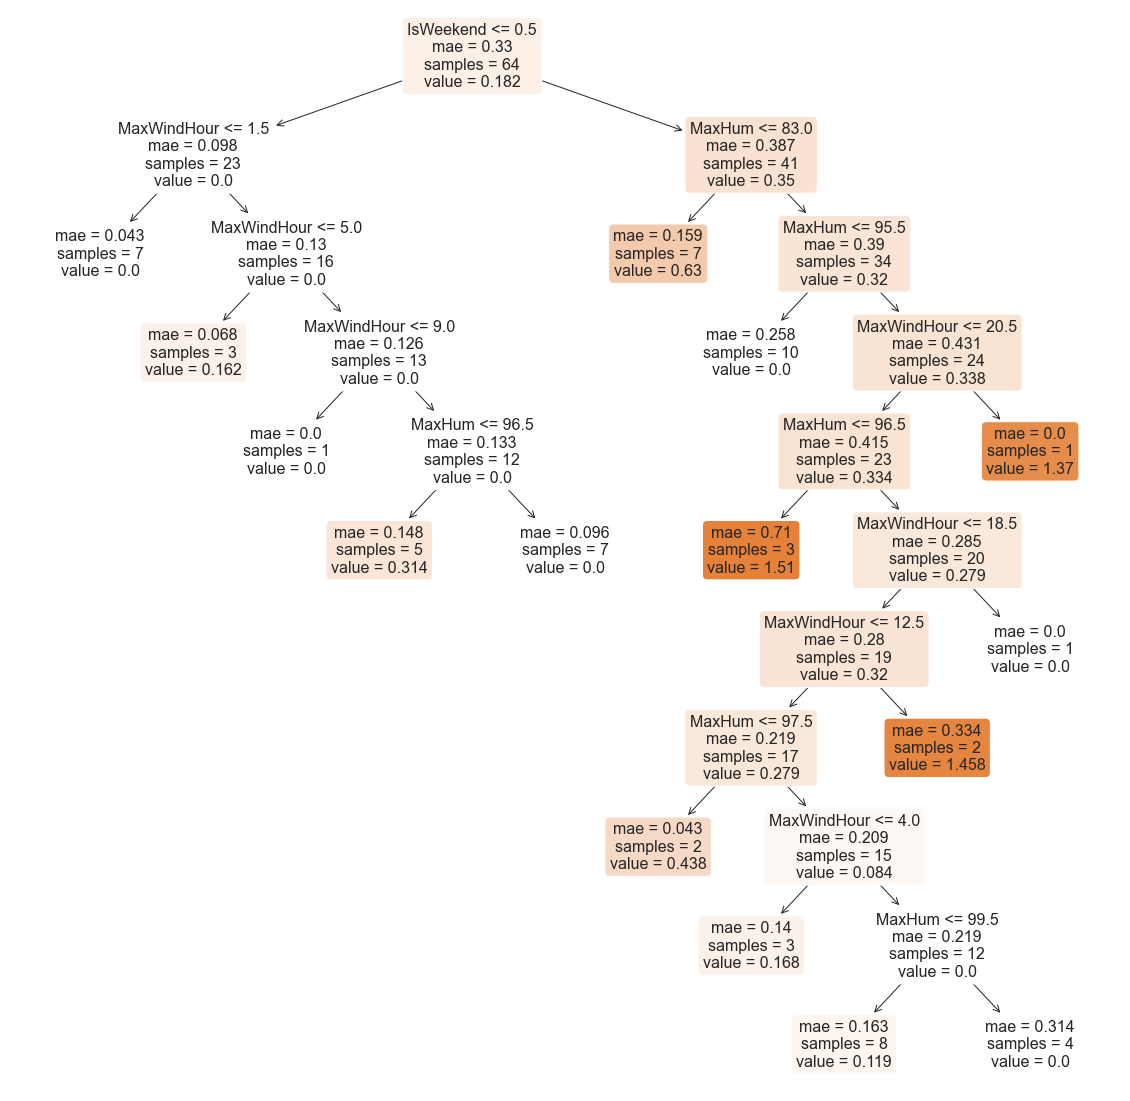

In [68]:
from sklearn.tree import plot_tree

rf.fit(Xrf, Yrf)

plt.figure(figsize=(20,20))

_ = plot_tree(rf.estimators_[0],
    feature_names=['MaxHum', 'MaxWindHour', 'IsWeekend'],
    filled=True,
    fontsize=16,
    rounded=True)

The left subtree looks somewhat reasonable:

If it is not weekend → go to the left where it's mostly 0 tips

    If the highest wind happened at 0 or 1 AM → 0 tips
    
    If the highest wind happened between 2 and 5 AM → small 0.16 tip

    If the highest wind happened between 5 and 9 AM → 0 tips 

    If the highest wind happened between after 9 AM and the hummidity was bellow 96.5 → medium tip 0.3
                                                                            otherwise → 0 tips
    
The first step reflects insights that we already gathered: Weekends are more profitable than week days. However the other steps are hardedr to understand.

That is especially true about the right subtree. 
    If the maximum hummidity is lower than 83 → medium 0.6 tip
    If the maximum hummidity is between 83 and 95 → no tip
    If the maximum hummidity is above 95.5 → maybe a big tip, maybe not.

The second tree in the forest which we don't display looks more similar to 

Also leaf nodes that are based on only one sample feel like they should lead to overfitting, however they perform best under Cross-Valildation and setting `min_samples_leaf` to anything higher than 1 lowers the accuracy.